## Integrantes

André de Macedo Wlodkovski

João Vitor Borges

Kalebe Rodrigues Szlachta

Lucas Eduardo Giovanini Marrega

## Imports

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
from math import sqrt
from skimage.color import rgb2gray,rgb2hsv
from skimage.filters import threshold_otsu, threshold_local
from skimage import io
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from skimage.feature import local_binary_pattern
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from random import sample
from skimage import data, color, segmentation
from skimage.draw import rectangle_perimeter
from skimage.transform import  resize
from skimage.filters import edges, median
from sklearn.metrics import plot_confusion_matrix
from skimage.measure import label, regionprops
from scipy import signal

# Exercise

A Brazilian Coin Dataset is available. Your task is to process the images to:


* Draw a rectangle bounding the coin
* Define a way to identify the currency value

NOTE:
a) You cannot use any machine learning approach (KNN, SVM, CNN,...). You should you on image processing based techniques such as pixel count, size, colors, etc.

b) You can use some drawing and image enhancement functions (filters). Check out the links below:

Drawing of geometric shapes: https://scikit-image.org/docs/dev/api/skimage.draw.html

Filters: https://scikit-image.org/skimage-tutorials/lectures/1_image_filters.html

Suggestion: Gaussian, median and average filter. Also, try some approaches with edge detectors.

In [ ]:
#Dataset Download
!wget https://www.inf.ufpr.br/aghochuli/dataset3.zip -O dataset.zip
!unzip dataset.zip

--2021-09-01 01:02:27--  https://www.inf.ufpr.br/aghochuli/dataset3.zip
Resolving www.inf.ufpr.br (www.inf.ufpr.br)... 200.17.202.113, 2801:82:80ff:8001:216:ccff:feaa:79
Connecting to www.inf.ufpr.br (www.inf.ufpr.br)|200.17.202.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35758483 (34M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  34.10M  13.1MB/s    in 2.6s    

2021-09-01 01:02:31 (13.1 MB/s) - ‘dataset.zip’ saved [35758483/35758483]

Archive:  dataset.zip
   creating: dataset3/
  inflating: dataset3/5_1477189488.jpg  
  inflating: dataset3/100_1477280538.jpg  
  inflating: dataset3/50_1477282872.jpg  
  inflating: dataset3/10_1477147452.jpg  
  inflating: dataset3/50_1477283088.jpg  
  inflating: dataset3/10_1477288506.jpg  
  inflating: dataset3/10_1477288476.jpg  
  inflating: dataset3/100_1477281726.jpg  
  inflating: dataset3/5_1477290534.jpg  
  inflating: dataset3/5_1477292040.jpg  
  inflating: d

## Carregando imagens

In [ ]:
#Carregando para uma lista de imagens
imgs = []
for img_path in os.listdir('./dataset3/'):  
       
     imgs.append([io.imread('./dataset3/' + img_path),img_path])

print(len(imgs),"images loaded")

1000 images loaded


## Mostrando imagens

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (480, 640, 3) looks like an RGB image
  


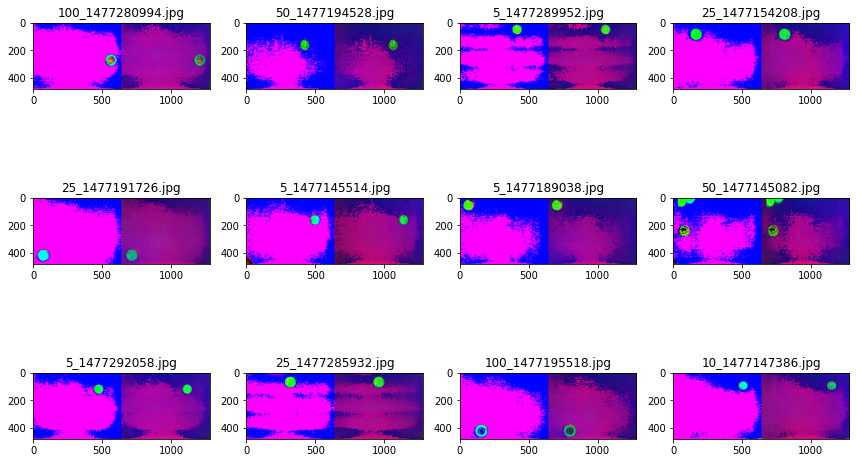

In [ ]:
#Showing some images
random.shuffle(imgs)

fig, axes = plt.subplots(3, 4, figsize=(12, 8))
ax = axes.ravel()

for i in range(12):
  ax[i].set_title(imgs[i][1])

  im = rgb2hsv(imgs[i][0])
  
  
  block_size = 35
  local_thresh = threshold_otsu(im, block_size)
  binary_local = im > local_thresh

  im_concat = np.concatenate([binary_local,im],axis=1)
  ax[i].imshow(im_concat,cmap=plt.cm.gray)


fig.tight_layout()
plt.show()

Vemos que existem vários desafios:


*   Ruídos
*   Sombra
*   Brilho
*   Escala

O primeiro passo é achar um processo para normalizar as imagens!

....binarize, aplique filtros, teste sistemas de cores distintos....

Mão na massa, agora é com você!



## Geradores de modelos

In [ ]:
def generate_knn(n_range, X_train, y_train, test_size=0.3, cv=5, plot=True):
  range_min, range_max = n_range
  best_model = None
  best_mean = 0
  means = []    #Resultados de cada KNN pra plotagem
  for i in range(range_min, range_max+1):
    print("\r"+str(i), end="")
    neigh = KNeighborsClassifier(n_neighbors=i)                                               #Cria modelo
    cv_scores = cross_val_score(neigh, X_train, y_train, cv=cv, scoring="balanced_accuracy")  #Faz scoragem baseada em accuracy

    mean = cv_scores.mean()
    means.append(mean)

    if mean > best_mean:
      best_model = neigh                                                                      #Encontrou um modelo melhor
      best_mean = mean
  
  if plot:
    plt.title("Neighbors X Mean Accuracy")
    plt.plot([i for i in range(range_min, range_max+1)], means)
    plt.show()
  
  best_model.fit(X_train, y_train)

  return best_model

def randomized_search(estimator, X_train, y_train, params, cv=5, plot=True):
  model = RandomizedSearchCV(estimator, params, random_state=0, cv=cv, scoring="balanced_accuracy", verbose=3)

  best_model = model.fit(X_train, y_train)

  if plot:
    results = pd.DataFrame(model.cv_results_)
    print(results)
  
  return best_model


## Extraindo a moeda

In [ ]:
block_size = 20

def detect_image(image):
  image = resize(image, (120,160), anti_aliasing=True)  #Resize para 160x120

  hsv_image = rgb2hsv(image)                            #Como visto nas plotagens acima, o HSV dá um destaque maior para as imagens
  saturation = hsv_image[:,:,1]                         #Canal S (HSV)
  filtered = median(saturation, np.ones((3,3)))         #Filtro (mediana)

  sat_thresh = threshold_otsu(filtered, block_size)     #Threshold automático
  sat_binary = filtered > sat_thresh

  labeled = label(sat_binary)                           #Identifica regiões conectadas
  regions = regionprops(labeled)                        #Extrai propriedades das regiões conectadas

  for region in regions:
    if region["Area"] < 20:                             #Ignora regiões muito pequenas
      continue
    
    minr, minc, maxr, maxc = region["BoundingBox"]      #r = row, c = column, coordenadas do retângulo da região

    ratio = (maxc - minc) / (maxr - minr)               

    if not (0.9 < ratio < 1.1):                         #Quero quadrados
      continue

    cropped = image[minr:maxr,minc:maxc]                #Moeda recortada
    return cropped, image, (minr, minc, maxr, maxc)     #Imagem recortada, original, coordenadas do retângulo
    
  return None                                           #Falhou


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

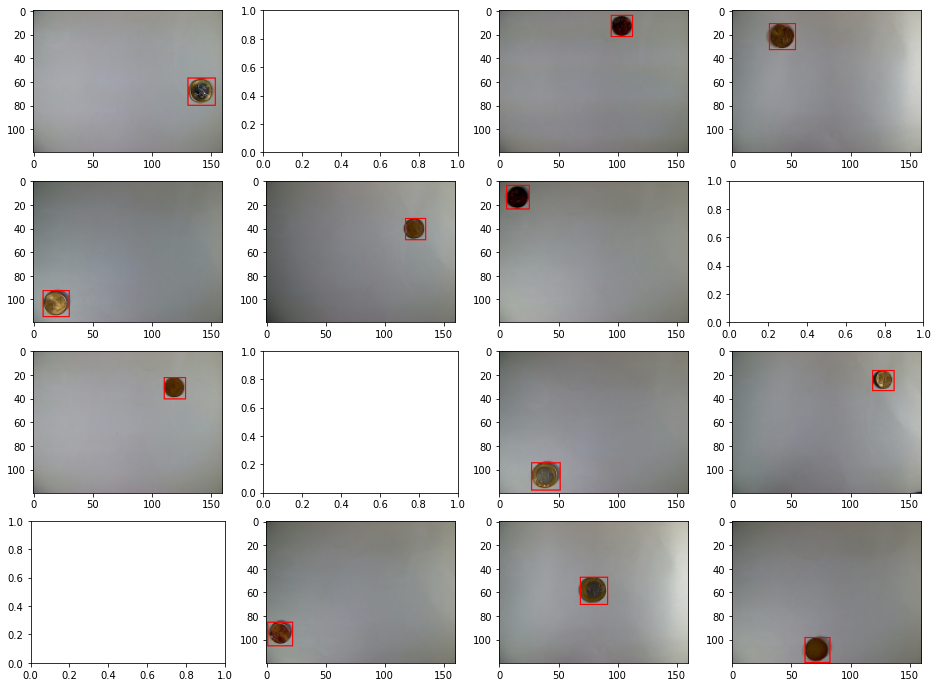

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
ax = axes.ravel()

#Pega 16 moedas e identifica elas
for i in range(16):
  detected_image = imgs[i][0].copy()
  result = detect_image(detected_image)
  if result is None:  #Verifica se ela foi encontrada ou não
    continue
  
  _, detected_image, (minr, minc, maxr, maxc) = result
  rr, cc = rectangle_perimeter((minr,minc), end=(maxr,maxc), shape=detected_image.shape, clip=True)
  detected_image[rr, cc] = (127,0,0)  #Desenha o retângulo vermelho
  ax[i].imshow(detected_image)
  
plt.show()

## LBP

In [ ]:
#Geração do conjunto com LBP

radius = 3
n_points = 8 * radius
shape = (64,64)

X = []
y = []

#Pega todas as imagens e gera um dataset
for i in range(1000):
  try:
    image, _, _ = detect_image(imgs[i][0]) #Tenta extrair a moeda
  except:
    continue                               #Falhou
  if image is None:
    continue                               #Falhou
  
  y.append(imgs[i][1].split("_")[0])       #Adiciona ao conjunto de respostas (target)
  lbp = local_binary_pattern(rgb2gray(image), n_points, radius, 'uniform')    #Aplica LBP, não pode ser aplicado diretamente em RGB, então foi convertido para grayscale por simplicidade e gera bons resultados
  X.append(resize(lbp, shape, anti_aliasing=True).ravel())                    #"Achata" a imagem em um vetor unidimensional e adiciona ao conjunto de dados (X)
  

print(len(y)) #Tamanho do dataset (max=1000)

889


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)    #Separa em treino e teste

### KNN

32

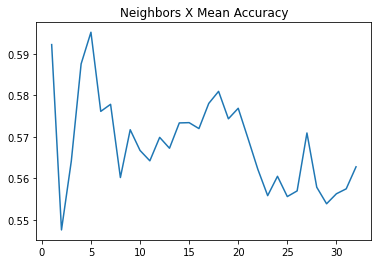

In [ ]:
knn_lbp = generate_knn((1,32), X_train, y_train)

In [ ]:
predictions_knn_lbp = knn_lbp.predict(X_test)

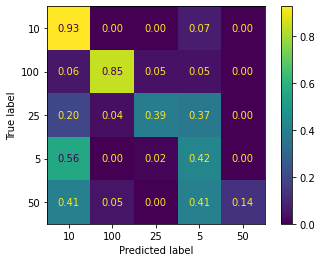

In [ ]:
plot_confusion_matrix(knn_lbp, X_test, y_test, normalize='true', values_format=".2f")

In [ ]:
accuracy_score(y_test, predictions_knn_lbp)

0.5880149812734082

## SVM

In [ ]:
params = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf", "poly"],
    "gamma": ["auto"]
}
svm_lbp = randomized_search(SVC(), X_train, y_train, params)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] kernel=linear, gamma=auto, C=0.1 ................................
[CV] .... kernel=linear, gamma=auto, C=0.1, score=0.715, total=   2.2s
[CV] kernel=linear, gamma=auto, C=0.1 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] .... kernel=linear, gamma=auto, C=0.1, score=0.667, total=   2.2s
[CV] kernel=linear, gamma=auto, C=0.1 ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s


[CV] .... kernel=linear, gamma=auto, C=0.1, score=0.703, total=   2.2s
[CV] kernel=linear, gamma=auto, C=0.1 ................................
[CV] .... kernel=linear, gamma=auto, C=0.1, score=0.693, total=   2.2s
[CV] kernel=linear, gamma=auto, C=0.1 ................................
[CV] .... kernel=linear, gamma=auto, C=0.1, score=0.688, total=   2.2s
[CV] kernel=rbf, gamma=auto, C=0.1 ...................................
[CV] ....... kernel=rbf, gamma=auto, C=0.1, score=0.200, total=   3.1s
[CV] kernel=rbf, gamma=auto, C=0.1 ...................................
[CV] ....... kernel=rbf, gamma=auto, C=0.1, score=0.200, total=   3.2s
[CV] kernel=rbf, gamma=auto, C=0.1 ...................................
[CV] ....... kernel=rbf, gamma=auto, C=0.1, score=0.200, total=   3.1s
[CV] kernel=rbf, gamma=auto, C=0.1 ...................................
[CV] ....... kernel=rbf, gamma=auto, C=0.1, score=0.200, total=   3.1s
[CV] kernel=rbf, gamma=auto, C=0.1 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  2.0min finished


   mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0       1.872273      0.006860  ...        0.015999                4
1       2.704473      0.015247  ...        0.000000                9
2       2.170066      0.015017  ...        0.012518                1
3       1.869108      0.020685  ...        0.015999                4
4       2.699598      0.018528  ...        0.003629                7
5       2.178004      0.014462  ...        0.012518                1
6       1.869414      0.013167  ...        0.015999                4
7       2.700075      0.015595  ...        0.003629                7
8       2.160357      0.017178  ...        0.012518                1

[9 rows x 16 columns]


In [ ]:
predictions_svm_lbp = svm_lbp.predict(X_test)

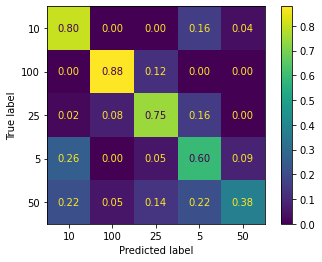

In [ ]:
plot_confusion_matrix(svm_lbp, X_test, y_test, normalize='true', values_format=".2f")

In [ ]:
accuracy_score(y_test, predictions_svm_lbp) #Accuracy geral

0.7078651685393258

A aplicação do LBP junto com as predições dos classificadores não garantiu estabilidade nas distribuições entre as classes

## PCA

In [ ]:
from sklearn.decomposition import PCA

shape = (64,64) #tamanho da imagem recortada

X = []
y = []
detected_images = []
pure_images = []

#Processa as imagens
for i in range(1000):
  try:
    image, _, _ = detect_image(imgs[i][0])
    pure_images.append(image)
  except:
    continue
  if image is None:
    continue
  
  y.append(imgs[i][1].split("_")[0])                                          #5, 10, 25, 50, 100
  detected_images.append(resize(image, shape, anti_aliasing=True).ravel())    #dados das imagens
  
print(len(y))

#Aplica PCA
pca = PCA(n_components=20)             #20 = melhor número dos testados (5,10,15,20,40,100)
X = pca.fit_transform(detected_images) #Cria conjunto de dados

889


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(list(zip(X, pure_images)), y, test_size=0.3)
pure_images_train = [y for x,y in X_train] #Imagens recortadas sem descritores para plotagem, isso foi adicionado depois que esse conjunto foi eleito o melhor
pure_images_test = [y for x,y in X_test]
X_train = [x for x,y in X_train]
X_test = [x for x,y in X_test]

32

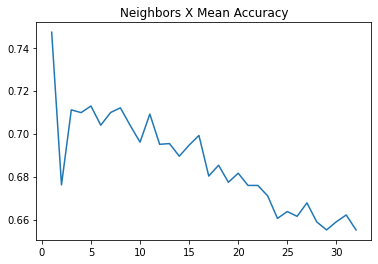

In [ ]:
knn_pca = generate_knn((1,32), X_train, y_train)

In [ ]:
predictions_knn_pca = knn_pca.predict(X_test)

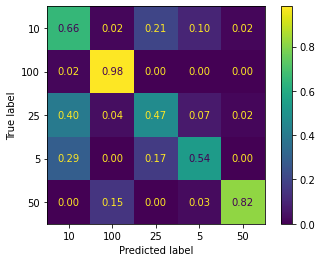

In [ ]:
plot_confusion_matrix(knn_pca, X_test, y_test, normalize='true', values_format=".2f")

In [ ]:
accuracy_score(y_test, predictions_knn_pca)

0.6741573033707865

### SVM

In [ ]:
params = {
    "C": [0.1, 1, 10], #C baixo = espaço equilibrado entre as classes, C alto = mais precisão, mas espaço mais restrito
    "kernel": ["linear", "rbf", "poly"], #foram escolhidos os 3 primeiros kernels pois existem muitos e leva tempo para ser treinado
    "gamma": ["auto"]
}
svm_pca = randomized_search(SVC(), X_train, y_train, params)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] kernel=linear, gamma=auto, C=0.1 ................................
[CV] .... kernel=linear, gamma=auto, C=0.1, score=0.824, total=   0.0s
[CV] kernel=linear, gamma=auto, C=0.1 ................................
[CV] .... kernel=linear, gamma=auto, C=0.1, score=0.817, total=   0.0s
[CV] kernel=linear, gamma=auto, C=0.1 ................................
[CV] .... kernel=linear, gamma=auto, C=0.1, score=0.849, total=   0.0s
[CV] kernel=linear, gamma=auto, C=0.1 ................................
[CV] .... kernel=linear, gamma=auto, C=0.1, score=0.807, total=   0.0s
[CV] kernel=linear, gamma=auto, C=0.1 ................................
[CV] .... kernel=linear, gamma=auto, C=0.1, score=0.834, total=   0.0s
[CV] kernel=rbf, gamma=auto, C=0.1 ...................................
[CV] ....... kernel=rbf, gamma=auto, C=0.1, score=0.398, total=   0.0s
[CV] kernel=rbf, gamma=auto, C=0.1 ...................................
[CV] ....... kern

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    3.0s finished


In [ ]:
predictions_svm_pca = svm_pca.predict(X_test)

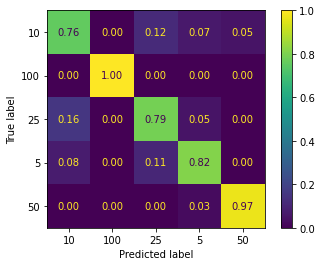

In [ ]:
plot_confusion_matrix(svm_pca, X_test, y_test, normalize='true', values_format=".2f")

In [ ]:
accuracy_score(y_test, predictions_svm_pca)

0.8539325842696629

In [ ]:
X_test_pca, y_test_pca = X_test, y_test

## LBP + PCA

In [ ]:
radius = 3 #foi testado 2, mas resultados ruins
n_points = 8 * radius
shape = (64,64)

X = []
y = []

for i in range(1000):
  try:
    image, _, _ = detect_image(imgs[i][0])
  except:
    continue
  if image is None:
    continue
  
  y.append(imgs[i][1].split("_")[0])
  lbp = local_binary_pattern(rgb2gray(image), n_points, radius, 'uniform')  #Aplica LBP
  X.append(resize(lbp, shape, anti_aliasing=True).ravel())
  

print(len(y))

#Aplica PCA
pca = PCA(n_components=100)
X = pca.fit_transform(X)

889


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

32

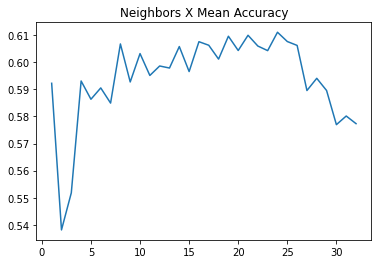

In [ ]:
knn_lbp_pca = generate_knn((1,32), X_train, y_train)

In [ ]:
predictions_knn_lbp_pca = knn_lbp_pca.predict(X_test)

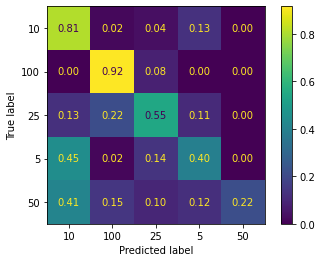

In [ ]:
plot_confusion_matrix(knn_lbp_pca, X_test, y_test, normalize='true', values_format=".2f")

In [ ]:
accuracy_score(y_test, predictions_knn_lbp_pca)

0.599250936329588

## SVM

In [ ]:
params = {
    "C": [0.1, 1],
    "kernel": ["linear", "rbf", "poly"],
    "gamma": ["auto"]
}
svm_lbp_pca = randomized_search(SVC(), X_train, y_train, params)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] kernel=linear, gamma=auto, C=0.1 ................................
[CV] .... kernel=linear, gamma=auto, C=0.1, score=0.580, total=   0.1s
[CV] kernel=linear, gamma=auto, C=0.1 ................................
[CV] .... kernel=linear, gamma=auto, C=0.1, score=0.665, total=   0.1s
[CV] kernel=linear, gamma=auto, C=0.1 ................................
[CV] .... kernel=linear, gamma=auto, C=0.1, score=0.622, total=   0.1s
[CV] kernel=linear, gamma=auto, C=0.1 ................................
[CV] .... kernel=linear, gamma=auto, C=0.1, score=0.691, total=   0.1s
[CV] kernel=linear, gamma=auto, C=0.1 ................................
[CV] .... kernel=linear, gamma=auto, C=0.1, score=0.543, total=   0.1s
[CV] kernel=rbf, gamma=auto, C=0.1 ...................................
[CV] ....... kernel=rbf, gamma=auto, C=0.1, score=0.200, total=   0.1s
[CV] kernel=rbf, gamma=auto, C=0.1 ...................................
[CV] ....... kern

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.2s finished


In [ ]:
predictions_svm_lbp_pca = svm_lbp_pca.predict(X_test)

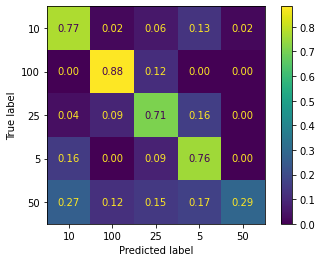

In [ ]:
plot_confusion_matrix(svm_lbp_pca, X_test, y_test, normalize='true', values_format=".2f")

In [ ]:
accuracy_score(y_test, predictions_svm_lbp_pca)

0.7078651685393258

## Análise geral dos resultados

Todos os modelos tiveram taxas de acertos moderadas a altas, com uma mínima de 58% e máxima de 85%. Devido à alta acurácia, o modelo escolhido a ser analisado será o SVM com o descritor PCA.

Esse modelo teve altos valores de acurácia em todas as classes, sendo a moeda de 10 centavos a menor delas - com 76% - e a de 1 real a maior, com uma taxa de acerto perfeita: 100%. O caso com mais classificações incorretas é quando o classificador classifica moedas de 25 centavos como moedas de 10 centavos. 16% das classificações das moedas como 10 centavos são, na verdade, moedas de 25 centavos.

## Erros de predições

O modelo escolhido para visualizar os erros foi o SVM com PCA, que obteve uma acurácia total de 85%.

As imagens abaixo mostram todas as moedas de determinada classe que não foram corretamente classificadas pelo modelo, por exemplo: na seção de moedas de 5, a primeira imagem é uma moeda de 5 que foi classificada como moeda de 10.

É possível ver semelhanças entre as moedas classificadas incorretamente, especialmente naquelas em que há pouca luminosidade. Há casos específicos, como por exemplo entre as moedas de 25 centavos, em que a foto contém elementos a mais, como a mão de uma pessoa.

In [ ]:
def idx_misses(y_true, predictions, value):
  idx = []
  for i, (y, pred) in enumerate(zip(y_true, predictions)):
    if y != pred and y == value:
      idx.append(i)
  
  return idx

### Moedas de 5

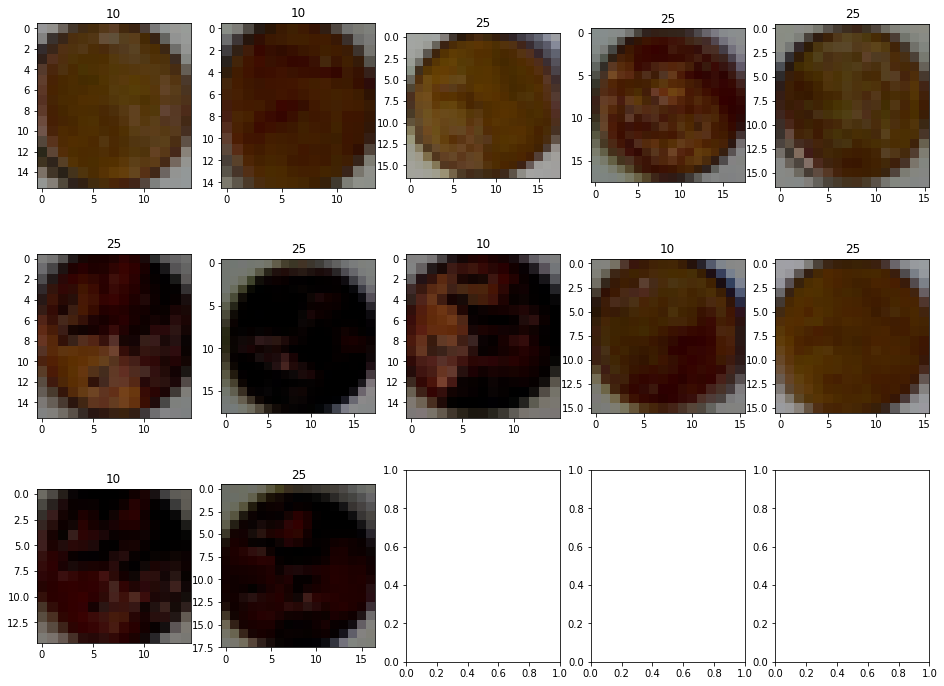

In [ ]:
misses = idx_misses(y_test_pca, predictions_svm_pca, '5')
width = int(sqrt(len(misses)))
height = len(misses)//width + 1

fig, axes = plt.subplots(width, height, figsize=(16, 12))
ax = axes.ravel()

for i, idx in enumerate(misses):
  ax[i].set_title(predictions_svm_pca[idx])
  ax[i].imshow(pure_images_test[idx])

plt.show()

### Moedas de 10

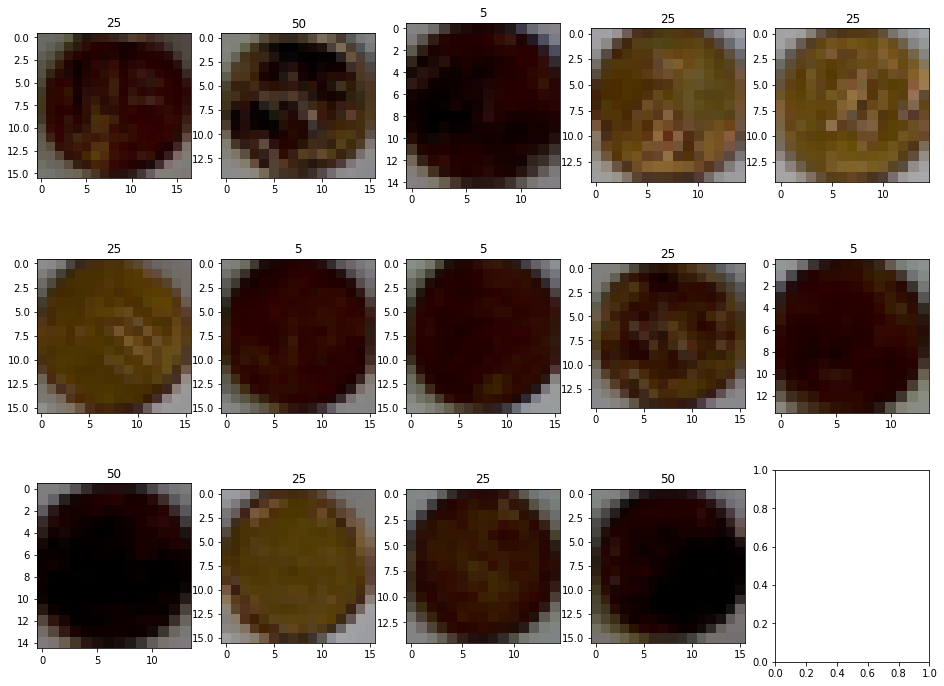

In [ ]:
misses = idx_misses(y_test_pca, predictions_svm_pca, '10')
width = int(sqrt(len(misses)))
height = len(misses)//width + 1

fig, axes = plt.subplots(width, height, figsize=(16, 12))
ax = axes.ravel()

for i, idx in enumerate(misses):
  ax[i].set_title(predictions_svm_pca[idx])
  ax[i].imshow(pure_images_test[idx])

plt.show()

### Moedas de 25

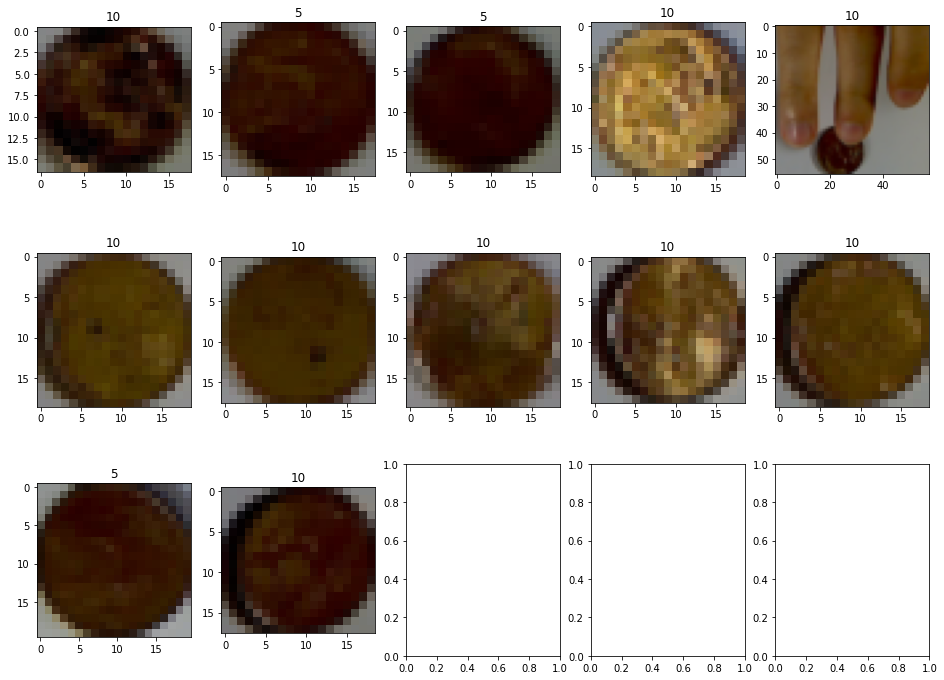

In [ ]:
misses = idx_misses(y_test_pca, predictions_svm_pca, '25')
width = int(sqrt(len(misses)))
height = len(misses)//width + 1

fig, axes = plt.subplots(width, height, figsize=(16, 12))
ax = axes.ravel()

for i, idx in enumerate(misses):
  ax[i].set_title(predictions_svm_pca[idx])
  ax[i].imshow(pure_images_test[idx])

plt.show()

### Moedas de 50

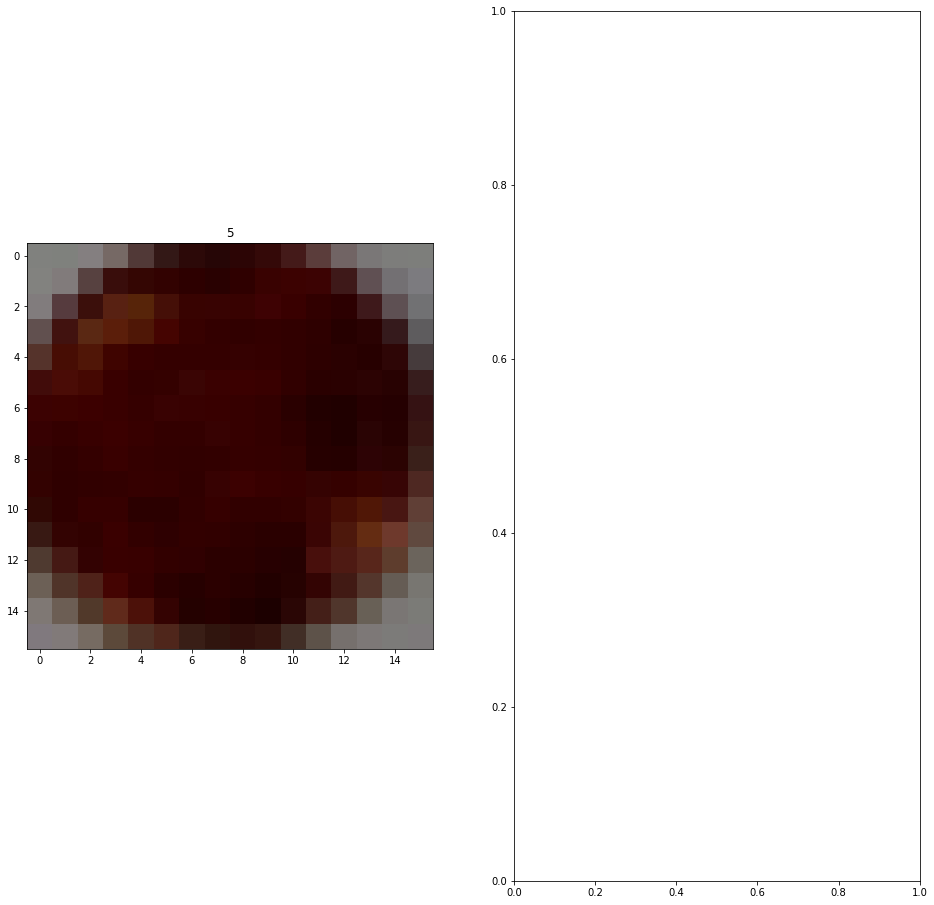

In [ ]:
misses = idx_misses(y_test_pca, predictions_svm_pca, '50')
width = int(sqrt(len(misses)))
height = len(misses)//width + 1

fig, axes = plt.subplots(width, height, figsize=(16, 12))
ax = axes.ravel()

for i, idx in enumerate(misses):
  ax[i].set_title(predictions_svm_pca[idx])
  ax[i].imshow(pure_images_test[idx])

plt.show()

### Moedas de 1 real
A acurácia nas moedas de 1 real foi de 100%.